In [1]:
%load_ext autoreload
%autoreload 2
!pip install ..

Processing /home/clement/Project/PhyloRNN/phyloRNN
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for phyloRNN: filename=phyloRNN-0.41-py3-none-any.whl size=463466 sha256=90f3f042ac7ff9e24aa9c544e3a3fc46dd8fa89f772467d07d0f20ca3969683e
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ef7vp7d/wheels/75/e5/f0/f031af9f02ec3ccd69c626c59d0ff6d65beb97028c575e91bf
Successfully built phyloRNN
  Attempting uninstall: phyloRNN
    Found existing installation: phyloRNN 0.41
    Uninstalling phyloRNN-0.41:
      Successfully uninstalled phyloRNN-0.41


In [2]:
import os
import matplotlib.pyplot as plt
import phyloRNN as pn
import sqlite3
import zlib
import numpy as np
import json
import tensorflow as tt

2025-02-25 11:18:21.307209: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 11:18:21.311223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.4/lib64:
2025-02-25 11:18:21.311240: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
print(tt.__version__)
print(np.__version__)

2.9.3
1.23.5


In [4]:
def plot_training_history(history, show=True, save_path=None):
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    if save_path:
        plt.savefig(save_path)
    if show:
        plt.show()
        
def train(fn, sqlite, taxa, site):

    training_file = os.path.join(os.getcwd(), fn)
    wd = os.path.dirname(training_file)
    model_name = "t50_s20"
    
    # load data
    sim, dict_inputs, dict_outputs = pn.rnn_in_out_dictionaries_from_sim(training_file,
                                                                         log_rates=False,
                                                                         log_tree_len=True,
                                                                         output_list=['per_site_rate','tree_len'],
                                                                         include_tree_features=False,
                                                                        sqlite = sqlite)
    
    # setup model architecture
    model_config = pn.rnn_config(n_sites=site, n_taxa=taxa) # default settings
    
    # build model
    model = pn.build_rnn_model(model_config,
                               optimizer=pn.keras.optimizers.RMSprop(1e-3),
                               print_summary=False)
    
    
    # training
    early_stop = pn.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=5,
                                                  restore_best_weights=True)
    
    history = model.fit(dict_inputs, dict_outputs,
                        epochs=10,
                        validation_split=0.2,
                        verbose=2,
                        callbacks=[early_stop],
                        batch_size=100)
    
    # save model
    pn.save_rnn_model(wd=wd, history=history, model=model, filename=model_name)

    return history

def simulate():
    
    sim = pn.simulator(
                   n_taxa = 20,
                   n_sites = 200,
                   n_eigen_features = 3,
                   min_rate = 0,  #
                   freq_uncorrelated_sites = 0.5,
                   freq_mixed_models = 0.05,
                   store_mixed_model_info = True,
                   tree_builder = 'nj',  # 'upgma'
        
                   subs_model_per_block = False,  # if false same subs model for all blocks
                   phyml_path = None,  # path to phyml and seq binaries
                   seqgen_path = None, # if None, it will try to use
                   ali_path = None,                                            # system-wide installed software
                   DEBUG=False,
                   verbose = True,
           format_output='sqlite')


        # training set
    sim.reset_prms(CPUs = 10,
                   n_sims = 200,
                   data_name = "training_data_taxa_20_sites200_2000",
                   base_seed = 1234)
    pn.simulate_parallel(sim, add_day_tag=False)

    # test set
    sim.reset_prms(CPUs = 10,
                   n_sims = 10,
                   data_name = "test_data_big",
                   run_phyml = True,
                   base_seed = 4321)
    pn.simulate_parallel(sim, add_day_tag=False)


In [5]:
simulate()


Running training_data_taxa_20_sites200_2000
mean_br_lengthmean_br_lengthmean_br_lengthmean_br_lengthmean_br_lengthmean_br_lengthmean_br_lengthmean_br_lengthmean_br_lengthmean_br_length          0.071819435358911970.010040798324005440.0088831633808834580.0029272452927650720.00145804796490605570.067359707829047310.0115424329098168780.0071871724460581380.0071726661578553460.01901641948186135









simulating tree...done
simulating data...simulating tree...done
simulating tree...done
simulating data...simulating tree...done
simulating data...simulating tree...done
simulating tree...done
simulating data...simulating tree...done
simulating data...simulating tree...done
simulating data...simulating tree...done
simulating data...simulating tree...done
simulating data...done
extracting features...done
mean_br_length 0.11837244156725678
simulating tree...done
simulating data...done
extracting features...done
mean_br_length 0.0006067667790041832
simulating tree...done
simulating data...done
s

FileNotFoundError: [Errno 2] No such file or directory: '/home/clement/Project/PhyloRNN/phyloRNN/notebooks/phyloRNN/ali_tmp/ali4324.phy0_true.tre'

Process ForkPoolWorker-26:
Process ForkPoolWorker-23:
Process ForkPoolWorker-18:
Process ForkPoolWorker-22:
Process ForkPoolWorker-19:
Process ForkPoolWorker-25:
Process ForkPoolWorker-24:
Process ForkPoolWorker-20:
Process ForkPoolWorker-17:
Process ForkPoolWorker-21:
Process ForkPoolWorker-31:
Process ForkPoolWorker-28:
Process ForkPoolWorker-32:
Process ForkPoolWorker-27:
Traceback (most recent call last):
Process ForkPoolWorker-29:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-30:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/clement/Project/PhyloRNN/phyloRNN/.devbox/nix/profile/default/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/clement/Project/PhyloRNN/phyloRNN/.devbox/nix/

In [6]:
!ls -lht

total 29M
-rw-rw-r-- 1 clement clement 319K Feb 24 21:41 sqlite_batching.ipynb
-rw-r--r-- 1 clement clement 6.1M Feb 24 21:40 training_data_taxa_20_sites200_2000.db
-rw-r--r-- 1 clement clement 320K Feb 24 20:59 training_data_taxa_10_sites100_200.db
-rw-r--r-- 1 clement clement  11M Feb 24 12:28 training_data_big.db
-rw-rw-r-- 1 clement clement 194K Feb 24 09:46 Explore_simulation_sqlite.ipynb
-rw-rw-r-- 1 clement clement 5.5M Jan 30 17:02 t50_s20_model.keras
-rw-rw-r-- 1 clement clement 1.6K Jan 30 17:02 t50_s20_history.pkl
-rw-r--r-- 1 clement clement 6.4M Jan 30 16:47 training_data.db
-rw-rw-r-- 1 clement clement 3.2K Dec 20 11:13 Monitor.ipynb


2025-02-25 11:18:39.807643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.4/lib64:
2025-02-25 11:18:39.807668: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-02-25 11:18:39.807685: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: starforge
2025-02-25 11:18:39.807689: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: starforge
2025-02-25 11:18:39.807761: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2025-02-25 11:18:39.807787: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: NOT_FOUND: could not find kernel module information in 

Creating blocks...
done
N. model parameters: 398675
Epoch 1/10
16/16 - 57s - loss: 2.0092 - per_site_rate_loss: 0.9832 - tree_len_loss: 1.0260 - val_loss: 1.6382 - val_per_site_rate_loss: 0.9065 - val_tree_len_loss: 0.7317 - 57s/epoch - 4s/step
Epoch 2/10
16/16 - 5s - loss: 1.7369 - per_site_rate_loss: 0.9788 - tree_len_loss: 0.7580 - val_loss: 1.6367 - val_per_site_rate_loss: 0.8993 - val_tree_len_loss: 0.7374 - 5s/epoch - 332ms/step
Epoch 3/10
16/16 - 5s - loss: 1.7558 - per_site_rate_loss: 0.9677 - tree_len_loss: 0.7881 - val_loss: 1.5923 - val_per_site_rate_loss: 0.8821 - val_tree_len_loss: 0.7102 - 5s/epoch - 336ms/step
Epoch 4/10
16/16 - 5s - loss: 1.5413 - per_site_rate_loss: 0.9427 - tree_len_loss: 0.5986 - val_loss: 1.4666 - val_per_site_rate_loss: 0.8738 - val_tree_len_loss: 0.5928 - 5s/epoch - 331ms/step
Epoch 5/10
16/16 - 5s - loss: 1.4373 - per_site_rate_loss: 0.9285 - tree_len_loss: 0.5087 - val_loss: 1.0492 - val_per_site_rate_loss: 0.8496 - val_tree_len_loss: 0.1996 - 5

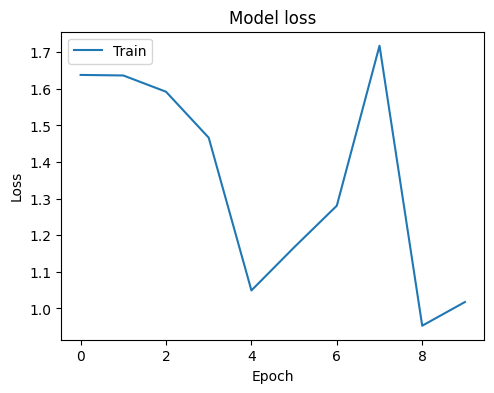

In [6]:
history_db =train('../data/training_data_taxa_20_sites200_2000.db', True, 20,200)
plot_training_history(history_db)